# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [53]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

## Читаме файл

In [54]:
df_raw = pd.read_csv('../data/checker_submits.csv')

## Создаем нужные колонки

In [55]:
df = pd.DataFrame()

## Копируем uid, labname, numTrials

In [56]:
df['uid'] = df_raw['uid']
df['labname'] = df_raw['labname']
df['numTrials'] = df_raw['numTrials']

## Преобразуем timestamp в datetime

In [57]:
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

## Извлекаем час и день недели

In [58]:
df['hour'] = df_raw['timestamp'].dt.hour
df['dayofweek'] = df_raw['timestamp'].dt.dayofweek  # 0 - понедельник, 6 - воскресенье

## OneHotEncoding для категориальных признаков

In [59]:
categorical_cols = ['uid', 'labname']
encoder = OneHotEncoder()

In [60]:
encoded_cat = encoder.fit_transform(df[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cat.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

## Удаляем исходные категориальные колонки и добавляем закодированные

In [61]:
df = df.drop(columns=categorical_cols)
df = pd.concat([df.reset_index(drop=True), encoded_cat_df.reset_index(drop=True)], axis=1)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   numTrials         1686 non-null   float64
 1   hour              1686 non-null   float64
 2   dayofweek         1686 non-null   int32  
 3   uid_user_0        1686 non-null   float64
 4   uid_user_1        1686 non-null   float64
 5   uid_user_10       1686 non-null   float64
 6   uid_user_11       1686 non-null   float64
 7   uid_user_12       1686 non-null   float64
 8   uid_user_13       1686 non-null   float64
 9   uid_user_14       1686 non-null   float64
 10  uid_user_15       1686 non-null   float64
 11  uid_user_16       1686 non-null   float64
 12  uid_user_17       1686 non-null   float64
 13  uid_user_18       1686 non-null   float64
 14  uid_user_19       1686 non-null   float64
 15  uid_user_2        1686 non-null   float64
 16  uid_user_20       1686 non-null   float64


## Масштабируем числовые признаки

In [62]:
scaler = StandardScaler()
df[['numTrials', 'hour']] = scaler.fit_transform(df[['numTrials', 'hour']])

## Сохраняем в CSV

In [86]:
df.to_csv('../data/dayofweek.csv', index=False)

## Оцениваем точность наивного алгоритма (предсказывающего самый частый класс)

In [64]:
most_common_day = df['dayofweek'].mode()[0]
accuracy_naive = (df['dayofweek'] == most_common_day).mean()
print(f"Самый частый день недели: {most_common_day}")
print(f"Точность наивного алгоритма: {accuracy_naive}")

Самый частый день недели: 3
Точность наивного алгоритма: 0.23487544483985764


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   numTrials         1686 non-null   float64
 1   hour              1686 non-null   float64
 2   dayofweek         1686 non-null   int32  
 3   uid_user_0        1686 non-null   float64
 4   uid_user_1        1686 non-null   float64
 5   uid_user_10       1686 non-null   float64
 6   uid_user_11       1686 non-null   float64
 7   uid_user_12       1686 non-null   float64
 8   uid_user_13       1686 non-null   float64
 9   uid_user_14       1686 non-null   float64
 10  uid_user_15       1686 non-null   float64
 11  uid_user_16       1686 non-null   float64
 12  uid_user_17       1686 non-null   float64
 13  uid_user_18       1686 non-null   float64
 14  uid_user_19       1686 non-null   float64
 15  uid_user_2        1686 non-null   float64
 16  uid_user_20       1686 non-null   float64


## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

## Данные

In [66]:

X = df.drop(columns=['dayofweek'])
y = df['dayofweek']

## Обучаем логистическую регрессию

In [67]:
model = OneVsRestClassifier(LogisticRegression(random_state=21, fit_intercept=False, max_iter=1000))
model.fit(X, y)

,estimator,LogisticRegre...ndom_state=21)
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,False
,intercept_scaling,1
,class_weight,None
,random_state,21


## Считаем точность

In [68]:
y_pred = model.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6209964412811388


## Получаем коэффициенты из всех моделей

In [69]:
coefs = np.array([est.coef_[0] for est in model.estimators_])

## Функция для построения barh графика

In [70]:
def plot_top_features(coefs, feature_names, top_n=10):
    importance = np.sum(np.abs(coefs), axis=0)
    top_indices = np.argsort(importance)[-top_n:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = importance[top_indices]
    
    plt.figure(figsize=(8,6))
    plt.barh(top_features[::-1], top_importance[::-1], color='skyblue')
    plt.xlabel('Importance (sum of abs coefficients)')
    plt.title(f'Top {top_n} most important features')
    plt.show()


## Строим график для обученной модели (топ-10 признаков)

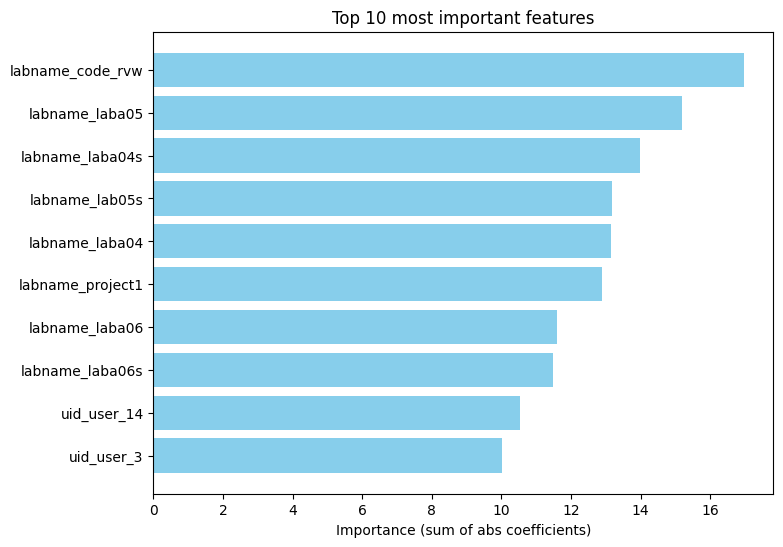

In [71]:
plot_top_features(coefs, X.columns.tolist(), top_n=10)

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

## Обучение базовой модели SVC с линейным ядром (через OVR)

In [72]:
svc_linear = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=21))
svc_linear.fit(X, y)

,estimator,SVC(kernel='l...ndom_state=21)
,n_jobs,None
,verbose,0
,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001


## Предсказания и точность

In [73]:
y_pred_linear = svc_linear.predict(X)
acc_linear = accuracy_score(y, y_pred_linear)
print(f"Accuracy (linear kernel): {acc_linear}")

Accuracy (linear kernel): 0.6126927639383155


## Пробуем разные ядра и считаем точность

In [74]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
accuracies = {}

for kernel in kernels:
    model = OneVsRestClassifier(SVC(kernel=kernel, probability=True, random_state=21))
    model.fit(X, y)
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    accuracies[kernel] = acc

print("Accuracies for different kernels:")
for k, v in accuracies.items():
    print(f"{k}: {v}")

Accuracies for different kernels:
linear: 0.6126927639383155
poly: 0.8653618030842231
rbf: 0.8641755634638197
sigmoid: 0.3499406880189798


## Функция для построения barh графика важности признаков

In [75]:
def plot_top_features(coefs, feature_names, top_n=10):
    importance = np.sum(np.abs(coefs), axis=0)
    top_indices = np.argsort(importance)[-top_n:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = importance[top_indices]
    
    plt.figure(figsize=(8,6))
    plt.barh(top_features[::-1], top_importance[::-1], color='coral')
    plt.xlabel('Importance (sum of abs coefficients)')
    plt.title(f'Top {top_n} most important features (linear kernel)')
    plt.show()

## Коэффициенты линейного ядра SVC (через OVR)

In [76]:
coefs_svc_linear = np.array([est.coef_[0] for est in svc_linear.estimators_])

## Рисуем график для топ-10 признаков

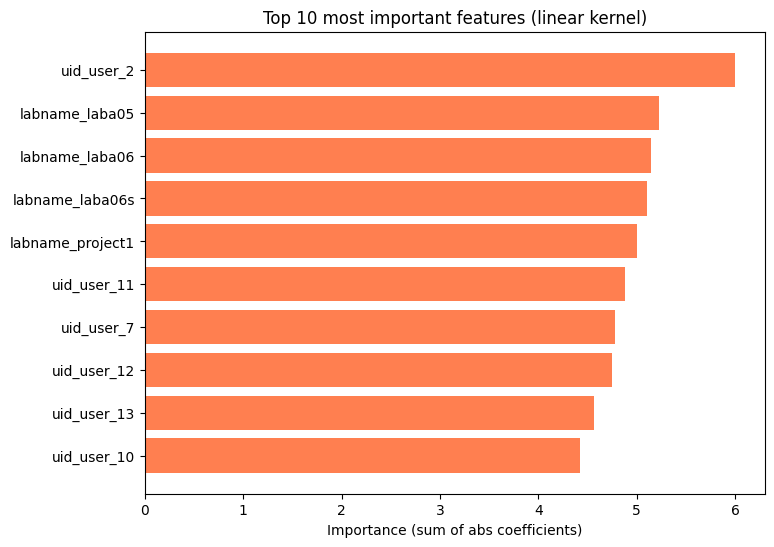

In [77]:
plot_top_features(coefs_svc_linear, X.columns.tolist(), top_n=10)

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

## Обучение базовой модели DecisionTree

In [78]:
dt_baseline = DecisionTreeClassifier(max_depth=4, random_state=21)
dt_baseline.fit(X, y)

y_pred_baseline = dt_baseline.predict(X)
acc_baseline = accuracy_score(y, y_pred_baseline)
print(f"Accuracy (max_depth=4): {acc_baseline}")

Accuracy (max_depth=4): 0.5516014234875445


## Попытки с разными max_depth и подсчёт точностей

In [79]:
depths = [2, 4, 6, 8]
accuracies = {}

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=21)
    dt.fit(X, y)
    y_pred = dt.predict(X)
    accuracies[depth] = accuracy_score(y, y_pred)

print("Accuracies for different max_depth values:")
for depth, acc in accuracies.items():
    print(f"max_depth={depth}: {acc}")

Accuracies for different max_depth values:
max_depth=2: 0.4389086595492289
max_depth=4: 0.5516014234875445
max_depth=6: 0.6637010676156584
max_depth=8: 0.7502965599051008


## Функция для построения barh графика важности признаков (если нет — вот простая)

In [80]:
def plot_top_features(importances, feature_names, top_n=10):
    # Важности уже не по классам, а просто вектор по признакам
    importance = np.abs(importances)
    top_indices = np.argsort(importance)[-top_n:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = importance[top_indices]
    
    plt.figure(figsize=(8,6))
    plt.barh(top_features[::-1], top_importance[::-1], color='seagreen')
    plt.xlabel('Feature Importance (absolute value)')
    plt.title(f'Top {top_n} most important features (Decision Tree)')
    plt.show()

## Рисуем график для базовой модели

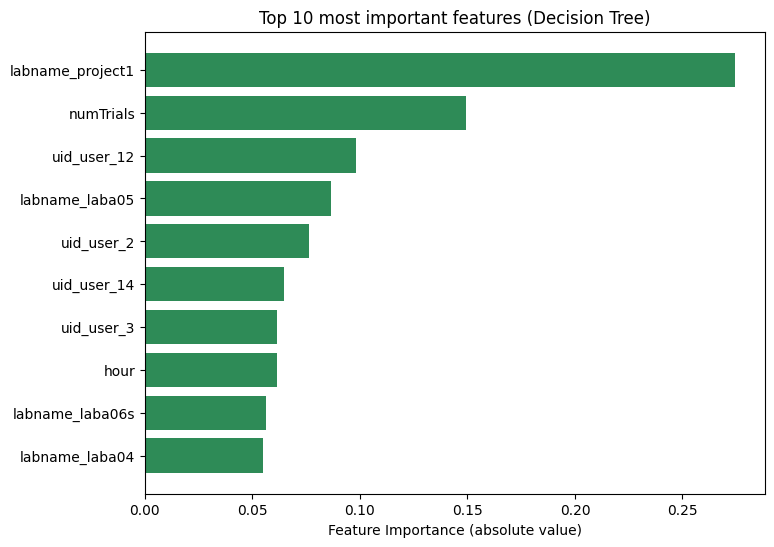

In [81]:
plot_top_features(dt_baseline.feature_importances_, X.columns.tolist(), top_n=10)

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

## Обучение базовой модели RandomForest

In [82]:
rf_baseline = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
rf_baseline.fit(X, y)

y_pred_baseline = rf_baseline.predict(X)
acc_baseline = accuracy_score(y, y_pred_baseline)
print(f"Accuracy (n_estimators=100, max_depth=25): {acc_baseline}")

Accuracy (n_estimators=100, max_depth=25): 1.0


## Попытки с разными значениями n_estimators и max_depth

In [83]:
n_estimators_list = [50, 100, 150]
max_depth_list = [10, 20, 25]

accuracies = {}

for n_est in n_estimators_list:
    for depth in max_depth_list:
        rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, random_state=21)
        rf.fit(X, y)
        y_pred = rf.predict(X)
        acc = accuracy_score(y, y_pred)
        accuracies[(n_est, depth)] = acc

print("Accuracies for different parameters (n_estimators, max_depth):")
for params, acc in accuracies.items():
    print(f"n_estimators={params[0]}, max_depth={params[1]}: {acc}")

Accuracies for different parameters (n_estimators, max_depth):
n_estimators=50, max_depth=10: 0.8701067615658363
n_estimators=50, max_depth=20: 0.9970344009489917
n_estimators=50, max_depth=25: 1.0
n_estimators=100, max_depth=10: 0.8855278766310795
n_estimators=100, max_depth=20: 0.99644128113879
n_estimators=100, max_depth=25: 1.0
n_estimators=150, max_depth=10: 0.8801897983392646
n_estimators=150, max_depth=20: 0.9976275207591934
n_estimators=150, max_depth=25: 1.0


## Функция для построения barh графика важности признаков

In [84]:
def plot_top_features(importances, feature_names, top_n=10):
    importance = np.abs(importances)
    top_indices = np.argsort(importance)[-top_n:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = importance[top_indices]
    
    plt.figure(figsize=(8,6))
    plt.barh(top_features[::-1], top_importance[::-1], color='mediumpurple')
    plt.xlabel('Feature Importance (absolute value)')
    plt.title(f'Top {top_n} most important features (Random Forest)')
    plt.show()

## Визуализация важности для базовой модели

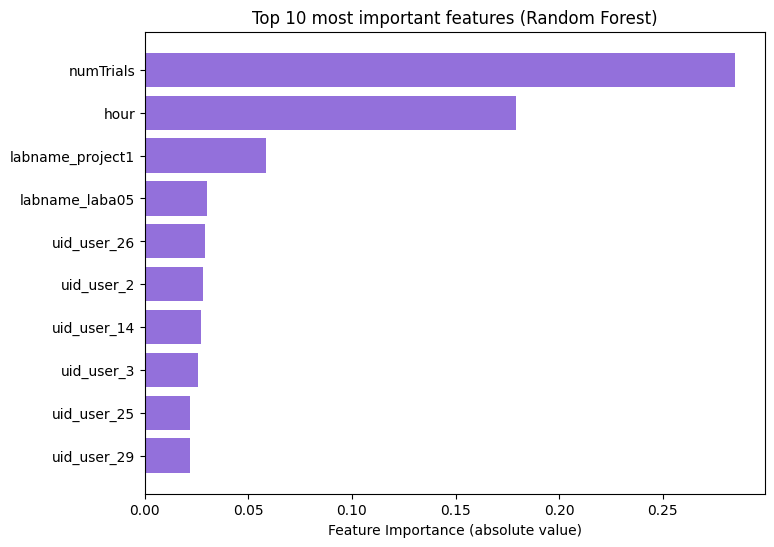

In [85]:
plot_top_features(rf_baseline.feature_importances_, X.columns.tolist(), top_n=10)